## LIBRARIES

In [33]:
pip install opencv-python


   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/39.0 MB 653.6 kB/s eta 0:01:00
   ---------------------------------------- 0.1/39.0 MB 1.1 MB/s eta 0:00:36
   ---------------------------------------- 0.2/39.0 MB 1.2 MB/s eta 0:00:34
   ---------------------------------------- 0.3/39.0 MB 1.5 MB/s eta 0:00:27
   ---------------------------------------- 0.4/39.0 MB 1.4 MB/s eta 0:00:28
   ---------------------------------------- 0.4/39.0 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.5/39.0 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.6/39.0 MB 1.5 MB/s eta 0:00:26
    --------------------------------------- 0.7/39.0 MB 1.6 MB/s eta 0:00:25
    --------------------------------------- 0.7/39.0 MB 1.6 MB/s eta 0:00:25
    --------------------------------------- 0.9/39.0 MB 1.7 MB/s eta 0:00:23
    -------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
pip install scikit-learn


  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/8.1 MB 812.7 kB/s eta 0:00:10
   - -------------------------------------- 0.2/8.1 MB 1.8 MB/s eta 0:00:05
   - -------------------------------------- 0.3/8.1 MB 1.9 MB/s eta 0:00:05
   -- ------------------------------------- 0.5/8.1 MB 2.3 MB/s eta 0:00:04
   --- ------------------------------------ 0.7/8.1 MB 2.7 MB/s eta 0:00:03
   ---- ----------------------------------- 0.9/8.1 MB 2.7 MB/s eta 0:00:03
   ----- ---------------------------------- 1.1/8.1 MB 2.9 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 3.1 MB/s eta 0:00:03
   ------- -------------------------------- 1.4/8.1 MB 3.1 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.1 MB 3.1 MB/s eta 0:00:03
   -------- -------------------


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data generators for training, validation, and testing

## DATA PREPROCESSING

### - DATA AUGUMENTATION

In [52]:
# train_gen = ImageDataGenerator(
#     rescale=1./255,
#     horizontal_flip=True,
#     rotation_range=10,
#     zoom_range=0.1

    # train_gen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=20,
    # zoom_range=0.2,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # horizontal_flip=True


train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale=1./255)



### - LOAD DATASETS

In [53]:
img_size = (224, 224)
batch_size = 32

In [ ]:
print("Training data loaded")
train_data = train_gen.flow_from_directory(
    r"D:\Minor Project Related\Data Sets ( Oily, Dry , Normal )\Final Set\train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
print("Validation data loaded")
val_data = val_gen.flow_from_directory(
    r"D:\Minor Project Related\Data Sets ( Oily, Dry , Normal )\Final Set\valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  
)
print("Testing data loaded")
test_data = test_gen.flow_from_directory(
    r"D:\Minor Project Related\Data Sets ( Oily, Dry , Normal )\Final Set\test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
print(" ")

# The ouput indicates the number of images in each set and the classes(Dry, Oily and Normal) detected in the dataset.

print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

Found 5356 images belonging to 3 classes.
Found 823 images belonging to 3 classes.
validation data loaded
Found 250 images belonging to 3 classes.
 
{'dry': 0, 'normal': 1, 'oily': 2}
{'dry': 0, 'normal': 1, 'oily': 2}
{'dry': 0, 'normal': 1, 'oily': 2}


## MODEL - MobileNetV2

In [46]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [47]:
#Freezing the base model :
# Why to freeze?
# - Prevents MobileNetV2 weights from changing
# - Preserves learned features (edges, textures, skin patterns)
# - Faster training
# - Prevents overfitting (important for small/imbalanced data)

base_model.trainable = False


#Last layers Unfreeze
# base_model.trainable = True

# for layer in base_model.layers[:-40]:
#     layer.trainable = False


In [48]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


## COMPILE THE MODEL

In [49]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## TRAINING THE MODEL

In [26]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

c:\Users\khati\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3412 - loss: 1.4129

c:\Users\khati\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - accuracy: 0.3414 - loss: 1.4119 - val_accuracy: 0.2956 - val_loss: 1.2192
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.4044 - loss: 1.0820 - val_accuracy: 0.3126 - val_loss: 1.2584
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4411 - loss: 1.0561 - val_accuracy: 0.3205 - val_loss: 1.2894
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4469 - loss: 1.0401 - val_accuracy: 0.3364 - val_loss: 1.3315
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.4837 - loss: 1.0173 - val_accuracy: 0.3454 - val_loss: 1.3701
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.4984 - loss: 0.9896 - val_accuracy: 0.3511 - val_loss: 1.3460
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.5213 - loss: 0.9710 - val_accuracy: 0.3386 - val_loss: 1.3495
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5195 - loss: 0.9583 - val_accuracy: 0.359

## TRAINING VS VALIDATION ( ACCURACY )

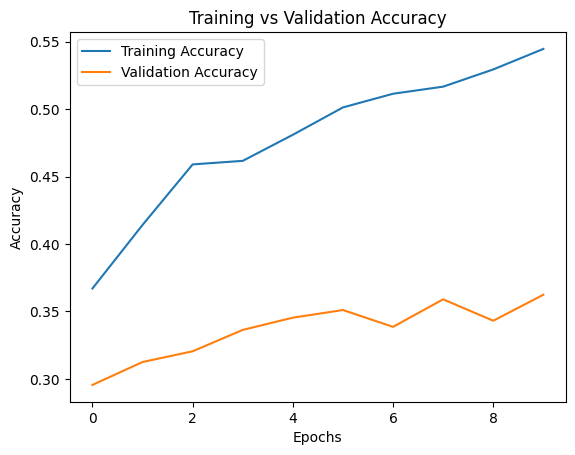

In [39]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

## TRAINING VS VALIDATION ( LOSS )

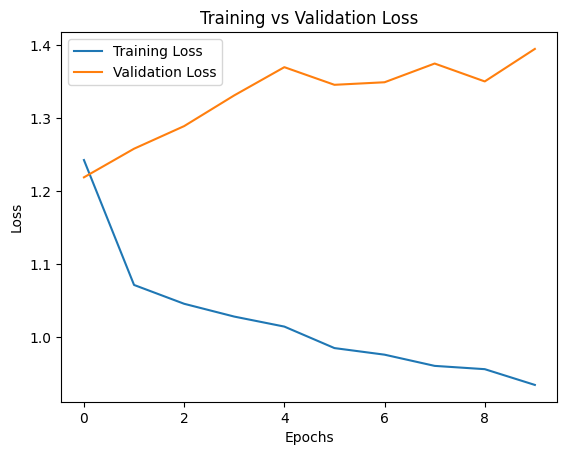

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()


In [29]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5463 - loss: 0.9212
Test Accuracy: 0.48929664492607117


In [30]:
model.save("skin_type_mobilenetv2.h5")

In [41]:
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['dry','normal','oily']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 710ms/step
Confusion Matrix:
[[52 20 10]
 [30 82 28]
 [51 28 26]]

Classification Report:
              precision    recall  f1-score   support

         dry       0.39      0.63      0.48        82
      normal       0.63      0.59      0.61       140
        oily       0.41      0.25      0.31       105

    accuracy                           0.49       327
   macro avg       0.48      0.49      0.47       327
weighted avg       0.50      0.49      0.48       327



## CONFUSION MATRIX

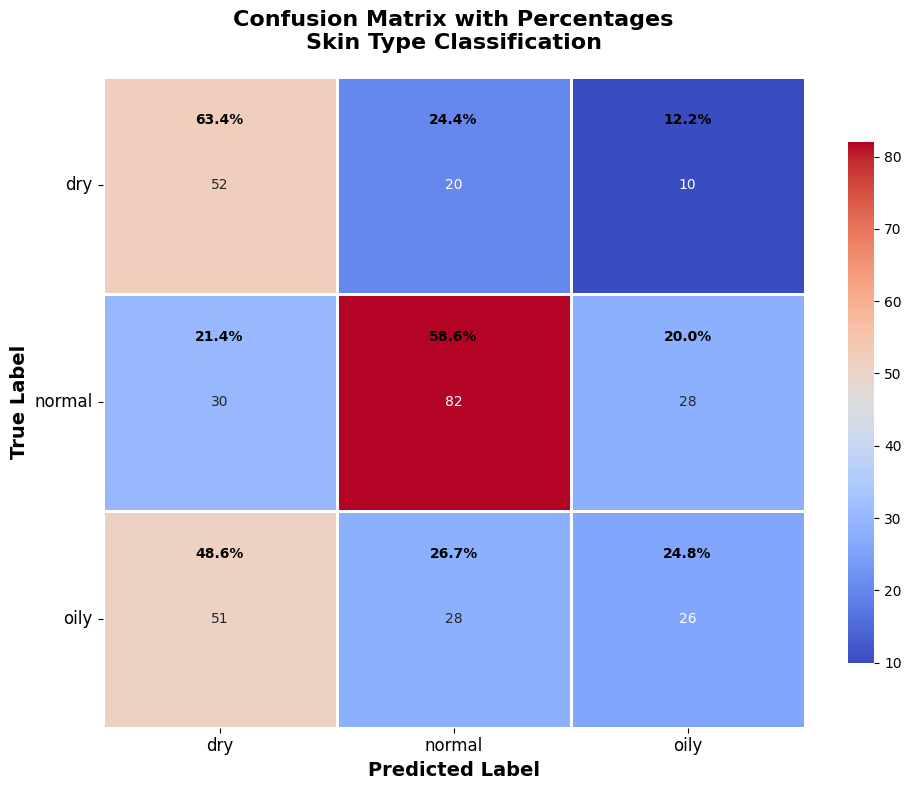

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
class_names = ['dry', 'normal', 'oily']

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
                 linewidths=2, linecolor='white',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar_kws={'shrink': 0.8})

# Add percentage text
for i in range(len(class_names)):
    for j in range(len(class_names)):
        total = cm[i].sum()
        percentage = f'{cm[i, j]/total*100:.1f}%'
        plt.text(j+0.5, i+0.2, percentage, 
                 ha='center', va='center', 
                 color='black', fontsize=10, fontweight='bold')

plt.title('Confusion Matrix with Percentages\nSkin Type Classification', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

In [42]:
# F-1 Score Calculation

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=train_data.class_indices.keys()))

              precision    recall  f1-score   support

         dry       0.39      0.63      0.48        82
      normal       0.63      0.59      0.61       140
        oily       0.41      0.25      0.31       105

    accuracy                           0.49       327
   macro avg       0.48      0.49      0.47       327
weighted avg       0.50      0.49      0.48       327



## PREDICT THE GIVEN IMAGE

In [ ]:
img_path = "C:\\Users\\swati\\OneDrive\\Desktop\\dataset\\dry\\dry13.jpeg"  #IMAGE WILL BE GIVEN HERE TO PREDICT
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
class_names = ['dry','normal','oily']

print("Predicted Skin Type:", class_names[np.argmax(prediction)])